In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydub
from pydub import AudioSegment
import os

def convert_mp3_to_wav(mp3_files, output_dir):
    for mp3_file in mp3_files:
        # MP3 to WAV conversion
        song = AudioSegment.from_mp3(mp3_file)
        wav_filename = os.path.basename(mp3_file).replace('.mp3', '.wav')
        wav_filepath = os.path.join(output_dir, wav_filename)
        song.export(wav_filepath, format="wav")

# 사람 음성 파일 변환
human_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/ai_voice/human/week6/', 'mp3')
convert_mp3_to_wav(human_audio_files, '/content/drive/MyDrive/PBL/ai_voice/human/week6/')


In [ ]:
import os
import random
from pydub import AudioSegment
import shutil

# 변환할 mp3 파일들이 있는 폴더 경로와 새로운 폴더 경로를 지정하세요.
source_folder = '/content/drive/MyDrive/PBL/ai_voice/human영어_패딩제거ver_755개'
target_folder = '/content/drive/MyDrive/PBL/ai_voice/human2_padding_cut_wav/'

# source_folder에서 mp3 파일만 선택합니다.
mp3_files = [f for f in os.listdir(source_folder) if f.endswith('.mp3')]

# 700개의 무작위 파일 선택 (만약 700개 미만의 파일이 있다면 모두 선택)
selected_files = random.sample(mp3_files, min(700, len(mp3_files)))

for file in selected_files:
    # 각각의 mp3 파일을 wav로 변환 후 target_folder에 저장합니다.
    audio = AudioSegment.from_mp3(os.path.join(source_folder, file))
    audio.export(os.path.join(target_folder, file.replace('.mp3', '.wav')), format='wav')

print(f"{len(selected_files)}개의 mp3 파일을 wav 형식으로 변환하여 {target_folder}에 저장했습니다.")


700개의 mp3 파일을 wav 형식으로 변환하여 /content/drive/MyDrive/PBL/ai_voice/human2_padding_cut_wav/에 저장했습니다.


In [ ]:
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import glob
import os

def get_files_from_dir(path, file_format):
    # 주어진 경로와 그 하위 경로에서 특정 형식의 파일들을 찾습니다.
    return glob.glob(os.path.join(path, f'**/*.{file_format}'), recursive=True)

# 데이터 증강 함수
def augment_data(y, sr):
    y_changed = librosa.effects.time_stretch(y, rate=0.81)
    y_changed = librosa.effects.pitch_shift(y_changed, sr=sr, n_steps=4)

    return y_changed

def extract_features(audio_files):
    features = []

    for audio_file in audio_files:
        try:
            y,sr=librosa.load(audio_file)

            # 원본 데이터에 대한 특성 추출
            mfccs = librosa.feature.mfcc(y=y,sr=sr)
            chroma_stft=librosa.feature.chroma_stft(y=y,sr=sr)
            spectral_contrast=librosa.feature.spectral_contrast(y=y,sr=sr)

            original_features=np.concatenate((np.mean(mfccs,axis=1),np.mean(chroma_stft,axis=1),np.mean(spectral_contrast,axis=1)))

            features.append(original_features)

            # 증강된 데이터에 대한 특성 추출
            y_augmented = augment_data(y,sr)

            mfccs_augmented=librosa.feature.mfcc(y=y_augmented,sr=sr)
            chroma_stft_augmented=librosa.feature.chroma_stft(y=y_augmented,sr=sr)
            spectral_contrast_augmented=librosa.feature.spectral_contrast(y=y_augmented,sr=sr)


            augmented_features=np.concatenate((np.mean(mfccs_augmented,axis=1),np.mean(chroma_stft_augmented,axis=1),np.mean(spectral_contrast_augmented,axis=-1)))

            features.append(augmented_features)

        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")

    return np.array(features)


ai_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/ai_voice/ai2_padding_cut_wav/', 'wav')
human_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/ai_voice/human2_padding_cut_wav/', 'wav')

# AI 음성 특징 추출 및 레이블 생성
ai_features_train_test_fullset=extract_features(ai_audio_files)
ai_labels_train_test_fullset=np.zeros(len(ai_features_train_test_fullset))

# 사람 음성 특징 추출 및 레이블 생성
human_features_train_test_fullset=extract_features(human_audio_files)
human_labels_train_test_fullset=np.ones(len(human_features_train_test_fullset))

X_train,X_val,y_train,y_val=train_test_split(np.concatenate([ai_features_train_test_fullset,human_features_train_test_fullset]),
                                             np.concatenate([ai_labels_train_test_fullset,human_labels_train_test_fullset]),test_size=0.2)

# 원-핫 인코딩을 위해 y 값을 변환
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=67
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=83
  warnings.warn(


In [ ]:
#아예첨부터새로짠모델&학습 이걸로 해야됨 밑에거말고

# 데이터 차원 재조정 (Conv1D 레이어는 3차원 입력을 기대합니다)
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)

# CNN 모델 구성
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# 최종 출력은 softmax를 사용한 2개 클래스에 대한 확률입니다.
# 두 개 이상의 카테고리가 있으므로 'softmax'를 사용합니다.
# 두 개의 카테고리만 있다면 'sigmoid'도 사용할 수 있습니다.
model.add(Dense(2, activation='softmax'))

# 모델 컴파일
optimizer = Adam(lr=0.0001)
early_stopping_monitor = EarlyStopping(patience=10)

# 분류 문제에서는 일반적으로 'categorical_crossentropy' 손실 함수를 사용합니다.
# optimizer로는 Adam을 사용하였습니다.
# metrics로 정확도('accuracy')를 확인합니다.

model.compile(loss='categorical_crossentropy', optimizer=optimizer ,metrics=['accuracy'])

print(model.summary())

history=model.fit(X_train,y_train,batch_size=64,
                  epochs=100,
                  validation_data=(X_val,y_val),
                  callbacks=[early_stopping_monitor])

# 학습 과정에서의 loss, accuracy, val_loss, val_accuracy 기록
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']
val_loss_history = history.history['val_loss']
val_accuracy_history = history.history['val_accuracy']

# loss, accuracy, val_loss, val_accuracy의 평균 계산
average_loss = sum(loss_history) / len(loss_history)
average_accuracy = sum(accuracy_history) / len(accuracy_history)
average_val_loss = sum(val_loss_history) / len(val_loss_history)
average_val_accuracy = sum(val_accuracy_history) / len(val_accuracy_history)

print(f"평균 loss: {average_loss}")
print(f"평균 accuracy: {average_accuracy}")
print(f"평균 val_loss: {average_val_loss}")
print(f"평균 val_accuracy: {average_val_accuracy}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 37, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 18, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 18, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 8, 128)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 128)            0

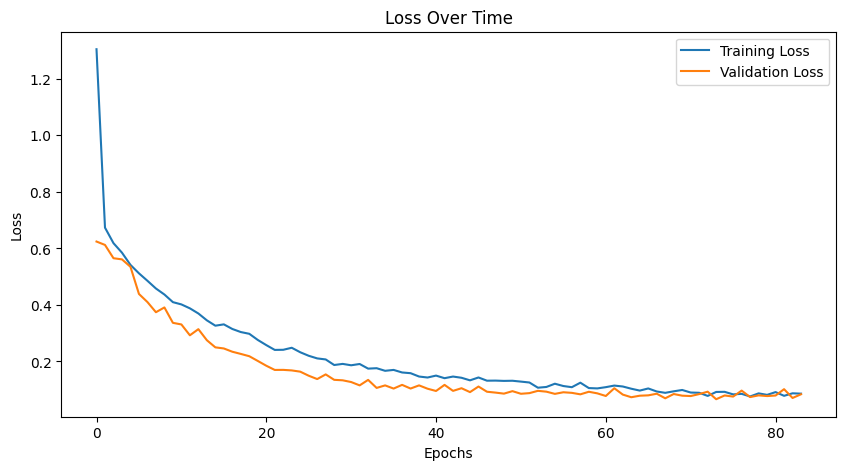

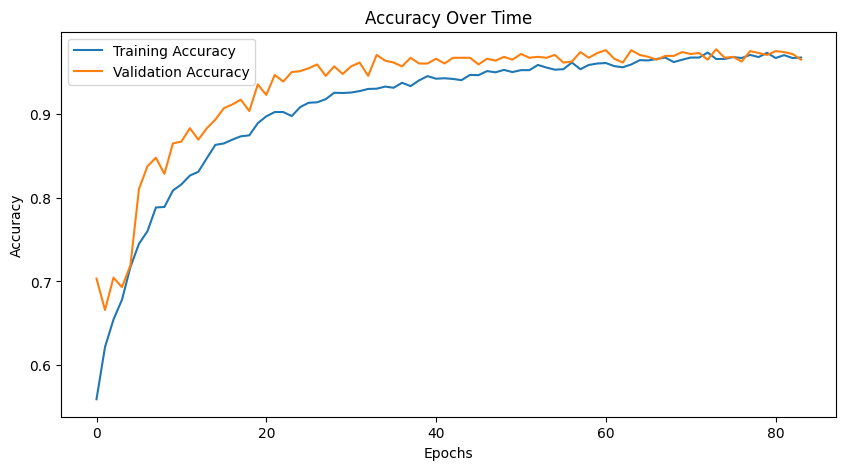

In [ ]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


In [ ]:
import os
import librosa
import soundfile as sf

# wav 파일들이 있는 폴더 경로
folder_path = '/content/drive/MyDrive/PBL/ai_voice/ai/week6'

for filename in os.listdir(folder_path):
    if filename.endswith('.wav'):
        # wav 파일 로드
        y, sr = librosa.load(os.path.join(folder_path, filename), sr=None)

        # 발화가 없는 부분 제거
        y_trimmed, index = librosa.effects.trim(y)

        # 변환된 wav 파일 저장 (원래의 이름에 '_trimmed' 추가)
        trimmed_filename = os.path.join(folder_path, os.path.splitext(filename)[0] + '_trimmed.wav')
        sf.write(trimmed_filename, y_trimmed, sr)



In [ ]:
def predict_audio_file(model, audio_file):
    features = []

    try:
        y, sr = librosa.load(audio_file)

        # 원본 데이터에 대한 특성 추출
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        original_features = np.concatenate((np.mean(mfccs,axis=1), np.mean(chroma_stft,axis=1), np.mean(spectral_contrast,axis=1)))

        features.append(original_features)

    except Exception as e:
        print(f"Error processing {audio_file}: {str(e)}")

    # 데이터 차원 재조정 (Conv1D 레이어는 3차원 입력을 기대합니다)
    features = np.expand_dims(features, axis=2)

    # 모델로부터 예측 결과 얻기
    prediction = model.predict(features)

    return prediction

# 제 3자의 음성 파일 경로
test_audio_file = '/content/drive/MyDrive/PBL/ai_voice/human/week6/2.wav'

# 제 3자의 음성 파일에 대한 예측 수행
prediction = predict_audio_file(model, test_audio_file)

# 예측 결과 출력 (각 클래스에 속할 확률)
print(prediction)

# 가장 확률이 높은 클래스 결정 및 출력
predicted_class = np.argmax(prediction)
print(f"Predicted class: {'AI' if predicted_class == 0 else 'Human'}")


1/1 [==============================] - 0s 42ms/step
[[6.790555e-08 9.999999e-01]]
Predicted class: Human
